*This script has been written by Max Bushala as part of Orpheus, a trading advisor program, built in collaboration with Noah Perelmuter, William Nichols, and Dasha Malaya; replications of code from this file are not permitted without express consent from the author.*

# **Orpheus**


---


## Trading Advisor


---


Orpheus is a trading advisor tool providing buy/sell/hold recommendations for US stocks in a portfolio that maximize portfolio return while reaching a target risk profile.

This Minimum Viable Unity (MVU) for Orpheus will be able to provide a single stock buy/sell/hold recommendation on a prediction horizon of one day ahead.

The Final Product for Orpheus will include horizon buy/sell/hold recommendations, with quantities, for multiple US stocks in a portfolio, that maximize portfolio return while reaching a target risk profile, as well as portfolio performance tracking.


*   *An extension being considered is to compute up-to-date sector financials by iterating through companies on the NYSE or NASDAQ using Yahoo Finance, performing equity valuation on each company, obtaining the sector of each company, weighing each financial metric by company market cap, to finally compute sector averages for each metric.*

*   *Another extension being considered is to run an equity valuation on every company on the NYSE or NASDAQ for each quarter of each company’s existence to then train multivariate time series models to predict stock prices on multi day horizons.*


*   *Yet another extension being considered is to include news sentiment analysis time series data.*

*   *Finally, we’ll expand on the recommendation logic for the final product, incorporating the considerations above into a machine learning decision model.*


We have transferred the code from our GitHub repository into this consolidated Google Colab notebook for ease of use.


*Read more: [Orpheus Project Notes](https://docs.google.com/document/d/1c5Dbvw8aLfwaK05wtmGKbgeH8__KHSw8MEZW6Sq-UHI/edit?usp=sharing)*

# **Install libraries**

In [ ]:
!pip install requests
!pip install pandas
!pip install xmltodict
!pip install beautifulsoup4
!pip install lxml
!pip install numpy
!pip install yfinance
!pip install torchvision==0.14.1 torchaudio==0.13.1 torchtext==0.14.1 torchdata==0.5.1
!pip install neuralprophet
!pip install matplotlib
!pip install time
!pip install plotly
!pip install plotly.express
!pip install statsmodel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 61.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.1+cu121
    Uninstal

Import libraries

In [389]:
import requests
import pandas as pd
import xmltodict
from bs4 import BeautifulSoup
import os, shutil
from lxml import etree
import numpy as np
import yfinance as yf
import datetime as dt
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
from matplotlib import pyplot as plt
import time
import plotly.express as px
import statsmodels.api as sm

# **Enter the symbol for the stock you want to value (i.e. "WMG" for Warner Music Group)**

In [390]:
stock = "PFE" # LEAVE ON PFIZER (PFE) FOR NOW!!!!!! IT HAS LONG TERM INVESTMENT DATA THAT IS MISSING FROM SOME OTHER STOCKS' FINANCIAL STATEMENTS REPORTED IN YFINANCE, SO THIS IS A GOOD STOCK PICK IN THE MEANTIME WHILE I FIX THIS.

**Complete** / Mostly Complete Code (Not being edited currently)

In [391]:
pd.set_option('display.precision', 10)

ticker = yf.Ticker(stock)
info = ticker.info
industry = info.get('industry')
industryKey = info.get('industryKey')
exchange = info.get('exchange')

history = ticker.history(period="3y")
closing_prices = history['Close'].astype(np.float64)
returns = closing_prices.pct_change().astype(np.float64)
variance_returns = np.var(returns.dropna())

fiscal_year = {'income_statements' : ticker.financials,
               'balance_sheets' : ticker.balance_sheet,
               'cash_flows' : ticker.cashflow}

quarterly = {'income_statements' : ticker.quarterly_financials,
               'balance_sheets' : ticker.quarterly_balance_sheet,
               'cash_flows' : ticker.quarterly_cashflow}

us_exchange_codes = {
    'NYQ' : ['NYSE', '^NYA'],
    'NMS' : ['NASDAQ Global Market Select', '^IXIC'],
    'NGM' : ['NASDAQ Global Market', '^IXIC'],
    'NCM' : ['NASDAQ Capital Market', '^IXIC'],
    'ASE' : ['NYSE American', '^XAX'], #NYSE American
} # https://www.sec.gov/files/company_tickers_exchange.json

# (NONE) (NYSE) (NASDAQ) (CHX) (BOX) (BX) (C2) (CBOE) (CboeBYX) (CboeBZX) (CboeEDGA) (CboeEDGX) (GEMX) (IEX) (ISE) (MIAX) (MRX) (NYSEAMER) (NYSEArca) (NYSENAT) (PEARL) (Phlx)

market_index = str(us_exchange_codes[exchange][1])
market_ticker = yf.Ticker(market_index)
market_info = market_ticker.info

market_history = market_ticker.history(period="3y")
market_closing_prices = market_history['Close']
market_history['Returns'] = market_history['Close'].pct_change().dropna()
market_returns = market_closing_prices.pct_change().dropna()
market_returns_variance = np.var(market_returns.dropna())

index_data = {
    'Stock Close': closing_prices,
    'Stock Returns': returns,
    'Stock Returns 20-Day Trailing Variances': returns.rolling(window=20).var(),
    'Market Close': market_closing_prices,
    'Market Returns': market_returns,
    'Market Returns 20-Day Trailing Variances': market_returns.rolling(window=20).var()
}

aligned_index_data = pd.DataFrame(index_data)


covariance = np.cov(market_returns.dropna().values, returns.dropna().values)[0, 1]

levered_beta = covariance/variance_returns


In [392]:

def get_bond_data():
    bonds_url = 'https://www.worldgovernmentbonds.com/'
    bd_resp = requests.get(bonds_url)
    soup = BeautifulSoup(bd_resp.content, 'html.parser')
    bond_table = soup.find('table', {'class' : 'homeBondTable sortable w3-table money pd44 -f14'})
    # bond_file = open('/Users/maxbushala/Downloads/bond_data.txt', 'w')
    # bond_file.write(str(bond_table.prettify()))
    # bond_file.close()
    bond_data = []
    for row in bond_table.find_all('tr'):
        row_data = []
        for cell in row.find_all('td'):
            row_data.append(cell.text)
        bond_data.append(row_data)
    bd_df = pd.DataFrame(bond_data).replace(r'\n|\t','',regex=True).replace('None', pd.NA)
    bd_df.drop(bd_df.columns[0],axis=1, inplace=True)
    bd_df = bd_df.drop([0,1])
    bd_df = bd_df[:-1]
    bd_df.columns = ['Country', 'S&P Rating', '10yr Bond Yield', 'Empty', 'Bank Rate', 'Spread vs Bund', 'Spread vs T-Note', 'Spread vs Bank Rate']
    bd_df = bd_df.replace(r"^ +| +$", r"", regex=True)
    bd_df['10yr Bond Yield'] = bd_df['10yr Bond Yield'].str.rstrip('%').astype('float')/100
    bd_df.drop('Empty', axis=1, inplace = True)
    return bd_df

bond_data = get_bond_data()

bond_data.style

# print(bond_data.iloc[0]['10yr Bond Yield'])

def print_bond_yields():
    print("10yr Bond Yield:")
    for i in range(len(bond_data)):
        print(f"{bond_data.iloc[i]['Country']}: {bond_data.iloc[i]['10yr Bond Yield']}")
    return None


us_bond_yield = bond_data.loc[bond_data['Country'] == 'United States', '10yr Bond Yield'].values[0]

def default_spread():
    bond_data['Spread'] = bond_data['10yr Bond Yield'] - us_bond_yield
    return bond_data

spread_table = default_spread()[['Country', '10yr Bond Yield', 'Spread']]

def expected_market_return():
    erm = market_history['Returns'].iloc[-1]
    return erm

erm = expected_market_return()

us_mature_erp = erm - us_bond_yield

today = dt.date.today()

company_ticker = stock #VZ, AMZN, WMG

pd.options.display.float_format = (
    lambda x: "{:,.0f}".format(x) if int(x) == x else "{:,.2f}".format(x)
)

headers = {
    'User-Agent' : 'maxbushala@gmail.com'
    }

# CHECK THIS OUT: https://www.sec.gov/Archives/edgar/data/1319161/000131916123000036/wmg-20230930.xsd
statement_keys_map = {
    "balance_sheet": [
        "balance sheet",
        "balance sheets",
        "statement of financial position",
        "consolidated balance sheets",
        "consolidated balance sheet",
        "consolidated financial position",
        "consolidated balance sheets - southern",
        "consolidated statements of financial position",
        "consolidated statement of financial position",
        "consolidated statements of financial condition",
        "combined and consolidated balance sheet",
        "condensed consolidated balance sheets",
        "consolidated balance sheets, as of december 31",
        "dow consolidated balance sheets",
        "consolidated balance sheets (unaudited)",
    ],
    "income_statement": [
        "income statement",
        "income statements",
        "statement of earnings (loss)",
        "statements of consolidated income",
        "consolidated statements of operations",
        "consolidated statement of operations",
        "consolidated statements of earnings",
        "consolidated statement of earnings",
        "consolidated statements of income",
        "consolidated statement of income",
        "consolidated income statements",
        "consolidated income statement",
        "condensed consolidated statements of earnings",
        "consolidated results of operations",
        "consolidated statements of income (loss)",
        "consolidated statements of income - southern",
        "consolidated statements of operations and comprehensive income",
        "consolidated statements of comprehensive income",
    ],
    "cash_flow_statement": [
        "cash flows statement",
        "cash flows statements",
        "statement of cash flows",
        "statements of consolidated cash flows",
        "consolidated statements of cash flows",
        "consolidated statement of cash flows",
        "consolidated statement of cash flow",
        "consolidated cash flows statements",
        "consolidated cash flow statements",
        "condensed consolidated statements of cash flows",
        "consolidated statements of cash flows (unaudited)",
        "consolidated statements of cash flows - southern",
    ],
}

statement_keys_map_scraped = None

operating_lease_items = ['LesseeOperatingLeaseLiabilityPaymentsDueNextTwelveMonths', 'us-gaap:LesseeOperatingLeaseLiabilityPaymentsDueYearTwo', 'us-gaap:LesseeOperatingLeaseLiabilityPaymentsDueYearThree', 'us-gaap:LesseeOperatingLeaseLiabilityPaymentsDueYearFour', 'us-gaap:LesseeOperatingLeaseLiabilityPaymentsDueYearFive', 'us-gaap:LesseeOperatingLeaseLiabilityPaymentsDueAfterYearSix']

def get_CIKs() -> dict:
    """
    Companies are indexed by CIK number on SEC's EDGAR.

    get_CIKs retrieves all company CIKs from SEC's EDGAR

    Returns:
        dict: company CIKs from the SEC's EDGAR.
        "Failed to retrieve data" (str): returns error string if CIK data could not be accessed with HTTP request.
    """

    tickers_url = 'https://www.sec.gov/files/company_tickers.json'

    cik_response = requests.get(tickers_url, headers = headers)

    if cik_response.status_code == 200:
        companyTickers = cik_response.json()
        return companyTickers
    else:
        return "Failed to retrieve data."

def get_company_CIK(company_ticker, sec_CIKs):
    """
    get_company_CIK retrieves a specific company's CIK using the company's ticker to search CIK from the list of CIKs in EDGAR.

    CIKs are 10 digit identifiers with leading 0s in the number. Company CIKs in the dictionary are missing leading 0s so we add them back.

    Params:
        company_ticker (str): company ticker to search
        sec_CIKs (dict): company CIKs for all companies listed in SEC's EDGAR

    Returns:
        company_CIK_adjusted (str): company CIK for the company being searched
        "No CIK found for {company_ticker}" (str): returns error string if company ticker is not listed in EDGAR.
    """
    sec_CIKs_length = len(sec_CIKs) - 1
    for i in range(0, sec_CIKs_length):
        if sec_CIKs[str(i)]['ticker'].lower() == company_ticker.lower():
            # add leading 0s
            company_CIK_adjusted = str(sec_CIKs[str(i)]['cik_str']).zfill(10)
            return company_CIK_adjusted
    return f"No CIK found for {company_ticker}"

sec_CIKs = get_CIKs()
company_CIK = get_company_CIK(company_ticker, sec_CIKs)


def get_filing_data(company_CIK):
    """
    get_filing_data retrieves company filings for the company being searched.

    Params:
        company_CIK (str): CIK of the company being searched in EDGAR

    Returns:
        filingMetadata ()
    """
    filingMetadata = requests.get(f'https://data.sec.gov/submissions/CIK{company_CIK}.json', headers=headers)
    if filingMetadata.status_code == 200:
        return filingMetadata.json()
    return "Failed to retrieve data."

filingData = get_filing_data(company_CIK)

def companyFacts(company_CIK):
    """
    companyFacts retrieves XBRL company facts for the company being searched.

    Params:
        company_CIK (str): CIK of the company being searched in EDGAR

    Returns:
        dict: JSON response containing XBRL company facts.
    """
    companyFacts = requests.get(f'https://data.sec.gov/api/xbrl/companyfacts/CIK{company_CIK}.json', headers=headers).json()
    return companyFacts

company_facts = companyFacts(company_CIK)['facts']['us-gaap']
labels_dict = {fact: details["label"] for fact, details in company_facts.items()}

filing_dataframe = pd.DataFrame.from_dict(filingData['filings']['recent']) # all the recent filings



#! Switch this to 10Qs and sum four for annual report
def get_10K(filings_df):
    """
    get_10K filters a filings DataFrame for the most recent 10-K filing.

    Params:
        filings_df (pd.DataFrame): DataFrame containing filings data

    Returns:
        pd.Series: A pandas Series for the most recent 10-K filing.
    """
    df_10K = filings_df[filings_df['form'] == '10-K']
    most_recent_10K = df_10K.sort_values(by='reportDate', ascending=False).head(1)
    # print(f"\nMost Recent 10K:\n{most_recent_10K}")
    return most_recent_10K.iloc[0]

def get_accession_number(most_recent_10K) -> str:
    """
    get_accession_number extracts the accession number from a Series representing the most recent 10-K filing.

    Params:
        most_recent_10K (pd.Series): A pandas Series representing the most recent 10-K filing.

    Returns:
        str: Accession number of the most recent 10-K filing.
    """
    return most_recent_10K['accessionNumber']

def get_primaryDocument(most_recent_10K):
    """
    get_primaryDocument gets the primary document for the most recent 10K.

    """
    return most_recent_10K['primaryDocument']

def get_report_date(most_recent_10K):
    return most_recent_10K['reportDate']

current_10K = get_10K(filing_dataframe)

accession_number = get_accession_number(current_10K).replace('-', '')
primaryDocument = get_primaryDocument(current_10K)
report_date = get_report_date(current_10K)

primaryDocument_no_extension = str(primaryDocument).split('.')[0]

form10K_url = f"https://www.sec.gov/Archives/edgar/data/{company_CIK}/{accession_number}/{primaryDocument_no_extension}_htm.xml"
#form10K_url = f"https://www.sec.gov/ixviewer/ix.html?doc=/Archives/edgar/data/{company_CIK}/{accession_number}/{primaryDocument}.htm"

def xml_to_dict(url):
    """
    Converts XML data from a specified URL to a JSON-like dictionary.

    Parameters:
    - url (str): The URL string of the XML data to be fetched and converted.

    Returns:
    - dict: A dictionary representing the parsed XML data. The structure of the dictionary
            matches the structure of the original XML, with tags as keys and tag contents
            as values.
    - None: Returns None if the request to the URL does not succeed (i.e., the HTTP status
            code is not 200).
    """
    xml_response = requests.get(url, headers=headers)
    if xml_response.status_code == 200:
        xml_content = xml_response.content
        # xml_json = json.dumps(xmltodict.parse(xml_content))
        xml_dict = xmltodict.parse(xml_content)
        return xml_dict
    return None

xml_parsed = xml_to_dict(form10K_url)

financialdata = xml_parsed['xbrl'] # THIS WOULD BE THE ONE TO USe ARELLE / PYTHON-XBRL LIBRARIES ON!!!
# print(financialdata.keys())

# usgaap_financials = {k: v for k, v in xml_parsed['xbrl'].items() if k.startswith('us-gaap')}
# print("\nUS-GAAP Financial Statements:\n")
# print(usgaap_financials.keys())

def save_doc(k, v, location):
    html_file = open(f"{location}/{k}.html", "w")
    try:
        print(f"Wrote {k} to html file.")
        # print(f"{type(v)}")
        if(type(v) is list):
            for i in v:
                if(k=='dei:SecurityExchangeName'):
                    print(i)
                html_file.write(str(i))
        elif(type(v) is dict):
            if(k=='000'):
                print(str(v['#text']))
            html_file.write(str(v['#text']))
        if(k=='000'):
            print(f"{v}")
    except:
        print(f"\nError writing html for {k}.")
        print(f"{type(v)}")
        print(f"{v}")
        html_file.close()
        os.remove(f"{location}/{k}.html")
    html_file.close()
    return

def save_data(financialdata):
    root_path = os.path.expanduser('~')
    print(root_path)
    location = f'{root_path}/Downloads/{company_ticker}FinancialData'

    # Open folder
    if not os.path.exists(location):
        os.makedirs(location)
        print(f"\nFolder '{location}' created.")
    else:
        print(f"\nFolder '{location}' already exists.")
        shutil.rmtree(f'{location}')
        print(f"\nFolder '{location}' deleted.")
        os.makedirs(location)
        print(f"\nFolder '{location}' created.")

    # Save HTML files with financial data to the folder
    for k, v in financialdata.items():
        save_doc(k, v, location)
    return None

def get_namespaces(url):
    # Fetch the content from the URL
    response = requests.get(url, headers = headers)
    if response.status_code == 200:
        # Parse the XML content from the response
        tree = etree.fromstring(response.content)

        # Extract namespaces from the root element
        namespaces = tree.nsmap

        # Handle the default namespace, if necessary
        if None in namespaces:
            default_ns_uri = namespaces[None]
            namespaces['default'] = default_ns_uri
            del namespaces[None]

        return namespaces
    else:
        raise ValueError("Failed to retrieve content from URL")

namespaces = get_namespaces(form10K_url)

def _get_file_name(report):
    """
    Extracts the file name from an XML report tag.

    Args:
        report (Tag): BeautifulSoup tag representing the report.

    Returns:
        str: File name extracted from the tag.
    """
    html_file_name_tag = report.find("HtmlFileName")
    xml_file_name_tag = report.find("XmlFileName")
    # Return the appropriate file name
    if html_file_name_tag:
        return html_file_name_tag.text
    elif xml_file_name_tag:
        return xml_file_name_tag.text
    else:
        return ""


def _is_statement_file(short_name_tag, long_name_tag, file_name):
    """
    Determines if a given file is a financial statement file.

    Args:
        short_name_tag (Tag): BeautifulSoup tag for the short name.
        long_name_tag (Tag): BeautifulSoup tag for the long name.
        file_name (str): Name of the file.

    Returns:
        bool: True if it's a statement file, False otherwise.
    """
    return (
        short_name_tag is not None
        and long_name_tag is not None
        and file_name  # Ensure file_name is not an empty string
        and "Statement" in long_name_tag.text
    )

def get_statement_file_names_in_filing_summary(ticker, accession_number, headers=None):
    """
    Retrieves file names of financial statements from a filing summary.

    Args:
        ticker (str): Stock ticker symbol.
        accession_number (str): SEC filing accession number.
        headers (dict): Headers for HTTP request.

    Returns:
        dict: Dictionary mapping statement types to their file names.
    """
    try:
        # Set up request session and get filing summary
        session = requests.Session()
        cik = company_CIK
        base_link = f"https://www.sec.gov/Archives/edgar/data/{cik}/{accession_number}"
        filing_summary_link = f"{base_link}/FilingSummary.xml"
        filing_summary_response = session.get(
            filing_summary_link, headers=headers
        ).content.decode("utf-8")

        # Parse the filing summary
        filing_summary_soup = BeautifulSoup(filing_summary_response, "lxml-xml")
        statement_file_names_dict = {}
        # Extract file names for statements
        for report in filing_summary_soup.find_all("Report"):
            file_name = _get_file_name(report)
            short_name, long_name = report.find("ShortName"), report.find("LongName")
            if _is_statement_file(short_name, long_name, file_name):
                statement_file_names_dict[short_name.text.lower()] = file_name
        return statement_file_names_dict
    except requests.RequestException as e:
        print(f"An error occurred: {e}")
        return {}

def get_taxonomy():
    taxonomy_url = f"https://www.sec.gov/Archives/edgar/data/{company_CIK.lstrip('0')}/{accession_number}/{primaryDocument_no_extension}.xsd"
    taxonomy_resp = requests.get(taxonomy_url, headers=headers)
    root = etree.fromstring(taxonomy_resp.content)
    nsmap = {'link': namespaces['link']}
    definitions = root.xpath('//link:definition', namespaces=nsmap)
    organized_list = []
    for _def in definitions:
        text = _def.text
        parts = text.split(' - ')
        organized_list.append(parts[1:])
    unique_tags = set([sublist[0] for sublist in organized_list])
    return [organized_list, definitions]

def get_filing_matches(substring, taxonomy_defs):
    matches = []
    for _def in taxonomy_defs:
        text = _def.text
        if substring in text:
            matches.append(text)
    return list(set(matches))

def get_statement_soup(ticker, accession_number, statement_name, headers, statement_keys_map):
    """
    Retrieves the BeautifulSoup object for a specific financial statement.

    Args:
        ticker (str): Stock ticker symbol.
        accession_number (str): SEC filing accession number.
        statement_name (str): has to be 'balance_sheet', 'income_statement', 'cash_flow_statement'
        headers (dict): Headers for HTTP request.
        statement_keys_map (dict): Mapping of statement names to keys.

    Returns:
        BeautifulSoup: Parsed HTML/XML content of the financial statement.

    Raises:
        ValueError: If the statement file name is not found or if there is an error fetching the statement.
    """
    session = requests.Session()
    base_link = f"https://www.sec.gov/Archives/edgar/data/{company_CIK}/{accession_number}"
    # Get statement file names
    statement_file_name_dict = get_statement_file_names_in_filing_summary(
        ticker, accession_number, headers
    )
    statement_link = None
    # Find the specific statement link
    for possible_key in statement_keys_map.get(statement_name.lower(), []):
        file_name = statement_file_name_dict.get(possible_key.lower())
        if file_name:
            statement_link = f"{base_link}/{file_name}"
            break
    if not statement_link:
        raise ValueError(f"Could not find statement file name for {statement_name}")
    # Fetch the statement
    try:
        statement_response = session.get(statement_link, headers=headers)
        statement_response.raise_for_status()  # Check for a successful request
        # Parse and return the content
        if statement_link.endswith(".xml"):
            return BeautifulSoup(
                statement_response.content, "lxml-xml", from_encoding="utf-8"
            )
        else:
            return BeautifulSoup(statement_response.content, "lxml")
    except requests.RequestException as e:
        raise ValueError(f"Error fetching the statement: {e}")

def get_table_from_url(url):
    # Fetch the page content
    try:
        response = requests.get(url, headers=headers, verify=False)
        response.raise_for_status()  # Check for HTTP request errors
    except Exception as e:
        print(f"Error fetching the page: {e}")
        return None

    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the first table
    table = soup.find('table')

    # Read the table into a DataFrame
    df = pd.read_html(str(table))[0]

    return df

# **In Development**

# **Load Data (Do Once)**

In [393]:
country_equity_risk_premiums = get_table_from_url('https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ctryprem.html')
rev_multiples = get_table_from_url('https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/psdata.html')
sector_betas = get_table_from_url('https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/Betas.html')
sector_cost_of_equity_and_capital = get_table_from_url('https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/wacc.htm')
sector_price_and_value_to_book_ratio = get_table_from_url('https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/pbvdata.html')

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'pages.stern.nyu.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings



Unverified HTTPS request is being made to host 'pages.stern.nyu.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'pages.stern.nyu.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings



Unverified HTTPS request is being made to host 'pages.stern.nyu.edu'. Adding certificate verification is strongly 

# **Output Data Preparation**

In [394]:
us_erp_data = country_equity_risk_premiums[country_equity_risk_premiums[0] == 'United States']
us_corporate_tax_rate = us_erp_data.iloc[0, 4]

substring = "Schedule of Operating Lease Liability Maturity"

taxonomy_definitions = get_taxonomy()[1]

statements_names = get_statement_file_names_in_filing_summary(company_ticker, accession_number, headers)

statement = financialdata.keys()

input_data = {
    '10K' : {
        'Total Revenue' : fiscal_year['income_statements'].loc['Total Revenue'],
        'Operating Income' : fiscal_year['income_statements'].loc['Operating Income'],
        'Interest Expense' : fiscal_year['income_statements'].loc['Interest Expense'],
        'Book Value of Equity' : fiscal_year['balance_sheets'].loc['Total Equity Gross Minority Interest'],
        'Book Value of Debt' : fiscal_year['balance_sheets'].loc['Total Debt'],
        'Cash and Marketable Securities' : fiscal_year['balance_sheets'].loc['Cash Cash Equivalents And Short Term Investments'],
        'Cross Holdings and Non-Operating Assets' : fiscal_year['balance_sheets'].loc['Long Term Equity Investment'],
        'Minority Interest' : fiscal_year['balance_sheets'].loc['Minority Interest']
    },
    '10Q' : {
        'Total Revenue' : quarterly['income_statements'].loc['Total Revenue'],
        'Operating Income' : quarterly['income_statements'].loc['Operating Income'],
        'Interest Expense' : quarterly['income_statements'].loc['Interest Expense'],
        'Book Value of Equity' : quarterly['balance_sheets'].loc['Total Equity Gross Minority Interest'],
        'Book Value of Debt' : quarterly['balance_sheets'].loc['Total Debt'],
        'Cash and Marketable Securities' : quarterly['balance_sheets'].loc['Cash Cash Equivalents And Short Term Investments'],
        'Cross Holdings and Non-Operating Assets' : quarterly['balance_sheets'].loc['Long Term Equity Investment'],
        'Minority Interest' : quarterly['balance_sheets'].loc['Minority Interest']
    },
    'Filing Alignment' : {
        'Most Recent Filing Date' : None,
        'Last 10K Filing Date' : None,
    },
    'Last Twelve Months' : {

    },
    'Other Inputs' : {
        'Years Since Last 10K': None, # Write code that takes the fraction of a year between the latest 10Q and 10K. If no 10Q since last 10K, set this to 1 and use the data from last 2 10Ks
        'Has R&D Expenses' : True,
        'Has Operating Leases' : True,
        'Current Shares Outstanding' : info.get('sharesOutstanding'),
        'Current Stock Price' : closing_prices.iloc[-1],
        'Effective Tax Rate' : fiscal_year['income_statements'].loc['Tax Rate For Calcs'].iloc[0],
        'Marginal Tax Rate' : us_corporate_tax_rate,
        'Revenue Growth Rate for Next Year' : None, # = ((Revenues from LTM / Revenues from Last 10K) ^ (1 / Years Since Last 10K) - 1) if Revenues from Last 10K > 0 else "NA",
    }
}

# 10K Input Data

input_10K_df = pd.DataFrame(input_data['10K']).T

input_10K_df.columns = pd.to_datetime(input_10K_df.columns)

filing_dates_10K = input_10K_df.columns.date.tolist()

formatted_10K_dates = [d.strftime('%Y/%m/%d') for d in filing_dates_10K]


# 10Q Input Data

input_10Q_df = pd.DataFrame(input_data['10Q']).T

input_10Q_df.columns = pd.to_datetime(input_10Q_df.columns)

filing_dates_10Q = input_10Q_df.columns.date.tolist()

formatted_10Q_dates = [d.strftime('%Y/%m/%d') for d in filing_dates_10Q]


# Linear Inputs

linear_input_df = pd.DataFrame([input_data['Other Inputs']]).T


# **Output**

In [395]:
print("\n______________________________________________________________________________________________________________________________________________________________________________")
print(f"____________________________________________________________________________VALUATION OF {company_ticker}__________________________________________________________________________________")
print("______________________________________________________________________________________________________________________________________________________________________________\n")

print("\nCompany Information:\n"+str(info))

print("\nExchange:\n"+str(exchange))

print("\nMost Recent Market Return:\n"+str(erm))

print("\nBeta:\n" + str(levered_beta))

print(f"\nSpreads:\n{spread_table}")

print(f"\nUS Bond Yield:\n{us_bond_yield}")

print(f"\nMature Market Equity Risk Premium:\n {us_mature_erp}")

print(f"\nReport Data Frame:\n{filing_dataframe['reportDate']}")

# save_data(financialdata)

print("\ncompany_CIK:\n" + str(company_CIK))

print("\naccession_number:\n" + str(accession_number))

print("\nprimaryDocument:\n" + str(primaryDocument))

print("\nreportDate:\n" + str(report_date))

print("\nNamespaces:\n" + str(namespaces))

print(f"\nMost Recent 10K:\n{current_10K}")

print("\nForm 10K URL:\n" + str(form10K_url))

# print(f"\n{financialdata.keys()}")

print("\nFinancial Statements:\n" + str(statements_names))

# print(f"\nMatch for {substring}:\n" + str(get_filing_matches(substring, taxonomy_definitions)[0]))

print("\nFinancial Statement Keys:\n" + str(statement))

print("\n______________________________________________________________________________________________________________________________________________________________________________\n")

print('\nFinancial Statement Data:\n')
print('\nIncome Statements')
print(quarterly['income_statements'].index)
print('\nBalance Sheets')
print(quarterly['balance_sheets'].index)
print('\nCash Flows')
print(quarterly['cash_flows'].index)
print()

print('\nFiscal Year\n______________\n')
print('\nIncome Statements')
print(fiscal_year['income_statements'])
print('\nBalance Sheets')
print(fiscal_year['balance_sheets'])
print('\nCash Flows')
print(fiscal_year['cash_flows'])
print('')

print('\nQuarterly\n______________\n')
print('\nIncome Statements')
print(quarterly['income_statements'])
print('\nBalance Sheets')
print(quarterly['balance_sheets'])
print('\nCash Flows')
print(quarterly['cash_flows'])
print('')

print("\n______________________________________________________________________________________________________________________________________________________________________________\n")

print('\nExternal Data (from Aswath Damodaran):\n__________________________________')

print("\nCountry Equity Risk Premium Data:\n" + str(country_equity_risk_premiums))

print("\nUS Sector Revenue Multiples Data:\n" + str(rev_multiples))

print("\nUS Sector Beta Data:\n" + str(sector_betas))

print("\nUS Sector Cost of Equity and Capital Data:\n" + str(sector_cost_of_equity_and_capital))

print("\nUS Sector Price and Value to Book Ratio Data:\n" + str(sector_price_and_value_to_book_ratio))

print("\n______________________________________________________________________________________________________________________________________________________________________________\n")

print('\nInput Data to Return:\n______________')

print("\n10K Input Data\n" + str(input_10K_df))

print("\n10Q Input Data\n" + str(input_10Q_df))

print("\nLinear Input Data\n" + str(linear_input_df))

print("\nFiling Dates for 10Ks from Yahoo Finance:\n" + str(formatted_10K_dates))

print("\nFiling Dates for 10Qs from Yahoo Finance:\n" + str(formatted_10Q_dates))



______________________________________________________________________________________________________________________________________________________________________________
____________________________________________________________________________VALUATION OF PFE__________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________


Company Information:
{'address1': '66 Hudson Boulevard East', 'city': 'New York', 'state': 'NY', 'zip': '10001-2192', 'country': 'United States', 'phone': '212 733 2323', 'website': 'https://www.pfizer.com', 'industry': 'Drug Manufacturers - General', 'industryKey': 'drug-manufacturers-general', 'industryDisp': 'Drug Manufacturers - General', 'sector': 'Healthcare', 'sectorKey': 'healthcare', 'sectorDisp': 'Healthcare', 'longBusinessSummary': "Pfizer Inc. discovers, d

*Note that the yahoo finance data does not have the most up to date 10Q, so the script will eventually pull the missing data from EDGAR's 10Q*

# **Time Series Modeling**

In [396]:
# Disable logging messages unless there is an error
set_log_level("ERROR")

set_random_seed(0)

# Check current structure
print(aligned_index_data.head())
print(aligned_index_data.columns)

# If 'Date' is not a column, reset the index to make it a column
if 'Date' not in aligned_index_data.columns:
    aligned_index_data.reset_index(inplace=True)
    aligned_index_data.rename(columns={'index': 'Date'}, inplace=True)

aligned_index_data = aligned_index_data.dropna()
aligned_index_data.head(20)

                           Stock Close  Stock Returns  \
Date                                                    
2021-04-12 00:00:00-04:00        32.83            NaN   
2021-04-13 00:00:00-04:00        33.00           0.01   
2021-04-14 00:00:00-04:00        33.01           0.00   
2021-04-15 00:00:00-04:00        33.39           0.01   
2021-04-16 00:00:00-04:00        34.25           0.03   

                           Stock Returns 20-Day Trailing Variances  \
Date                                                                 
2021-04-12 00:00:00-04:00                                      NaN   
2021-04-13 00:00:00-04:00                                      NaN   
2021-04-14 00:00:00-04:00                                      NaN   
2021-04-15 00:00:00-04:00                                      NaN   
2021-04-16 00:00:00-04:00                                      NaN   

                           Market Close  Market Returns  \
Date                                              

,Date,Stock Close,Stock Returns,Stock Returns 20-Day Trailing Variances,Market Close,Market Returns,Market Returns 20-Day Trailing Variances
20,2021-05-10 00:00:00-04:00,35.74,0.01,0.00,"16,516.83",-0.00,0.00
21,2021-05-11 00:00:00-04:00,35.29,-0.01,0.00,"16,355.62",-0.01,0.00
22,2021-05-12 00:00:00-04:00,35.59,0.01,0.00,"16,042.97",-0.02,0.00
23,2021-05-13 00:00:00-04:00,35.96,0.01,0.00,"16,181.63",0.01,0.00
24,2021-05-14 00:00:00-04:00,35.89,-0.00,0.00,"16,415.36",0.01,0.00
25,2021-05-17 00:00:00-04:00,35.97,0.00,0.00,"16,422.96",0.00,0.00
26,2021-05-18 00:00:00-04:00,35.91,-0.00,0.00,"16,337.73",-0.01,0.00
27,2021-05-19 00:00:00-04:00,35.72,-0.01,0.00,"16,233.32",-0.01,0.00
28,2021-05-20 00:00:00-04:00,35.98,0.01,0.00,"16,350.45",0.01,0.00
29,2021-05-21 00:00:00-04:00,35.82,-0.00,0.00,"16,375",0.00,0.00


In [397]:
aligned_index_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 736 entries, 20 to 755
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype                           
---  ------                                    --------------  -----                           
 0   Date                                      736 non-null    datetime64[ns, America/New_York]
 1   Stock Close                               736 non-null    float64                         
 2   Stock Returns                             736 non-null    float64                         
 3   Stock Returns 20-Day Trailing Variances   736 non-null    float64                         
 4   Market Close                              736 non-null    float64                         
 5   Market Returns                            736 non-null    float64                         
 6   Market Returns 20-Day Trailing Variances  736 non-null    float64                         
dtypes: datetime64[ns, America/New_Y

**Stock Price Time Series Model**

In [398]:
stock_price_time_series = pd.DataFrame([aligned_index_data['Date'],aligned_index_data['Stock Close']]).T.rename(columns={'Date' : 'ds', 'Stock Close' : 'y'})[['ds','y']]

stock_price_time_series.head(20)

,ds,y
20,2021-05-10 00:00:00-04:00,35.74
21,2021-05-11 00:00:00-04:00,35.29
22,2021-05-12 00:00:00-04:00,35.59
23,2021-05-13 00:00:00-04:00,35.96
24,2021-05-14 00:00:00-04:00,35.89
25,2021-05-17 00:00:00-04:00,35.97
26,2021-05-18 00:00:00-04:00,35.91
27,2021-05-19 00:00:00-04:00,35.72
28,2021-05-20 00:00:00-04:00,35.98
29,2021-05-21 00:00:00-04:00,35.82


In [399]:
stock_price_ts_model = NeuralProphet()

stock_price_ts_model.set_plotting_backend("matplotlib")

stock_price_metrics = stock_price_ts_model.fit(stock_price_time_series,
                    freq='D', epochs=10)

Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [400]:
stock_price_future = stock_price_ts_model.make_future_dataframe(stock_price_time_series, periods=365, n_historic_predictions=len(stock_return_time_series))
stock_price_forecast = stock_price_ts_model.predict(stock_price_future)

Predicting: 23it [00:00, ?it/s]

In [401]:
stock_price_forecast

,ds,y,yhat1,trend,season_yearly,season_weekly
0,2021-05-10 04:00:00,35.74,39.48,34.49,-1.41,6.40
1,2021-05-11 04:00:00,35.29,39.15,34.51,-1.42,6.06
2,2021-05-12 04:00:00,35.59,39.46,34.53,-1.43,6.36
3,2021-05-13 04:00:00,35.96,39.08,34.54,-1.43,5.96
4,2021-05-14 04:00:00,35.89,39.77,34.56,-1.42,6.63
...,...,...,...,...,...,...
1096,2025-04-07 04:00:00,None,13.04,5.69,0.95,6.40
1097,2025-04-08 04:00:00,None,12.64,5.65,0.90,6.09
1098,2025-04-09 04:00:00,None,12.83,5.61,0.85,6.37
1099,2025-04-10 04:00:00,None,12.32,5.58,0.79,5.96


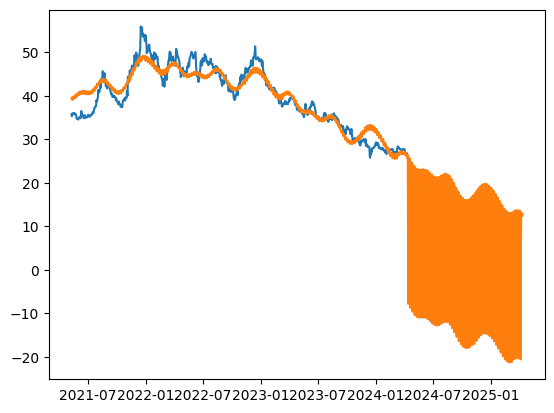

In [402]:
plt.plot(stock_price_forecast.ds, stock_price_forecast.y)
plt.plot(stock_price_forecast.ds, stock_price_forecast.yhat1)

In [403]:
fig = px.line(stock_price_forecast, x = 'ds',y = 'yhat1',title = 'Predicted Stock Price')
fig.add_scatter(x=stock_price_time_series['ds'], y = stock_price_time_series['y'], mode='lines')
fig.add_scatter(x=stock_price_time_series['ds'], y = stock_price_time_series['y'].rolling(window=12).mean(), mode='lines')

fig.update_xaxes(
    rangeslider_visible= True
                   )
fig.show()

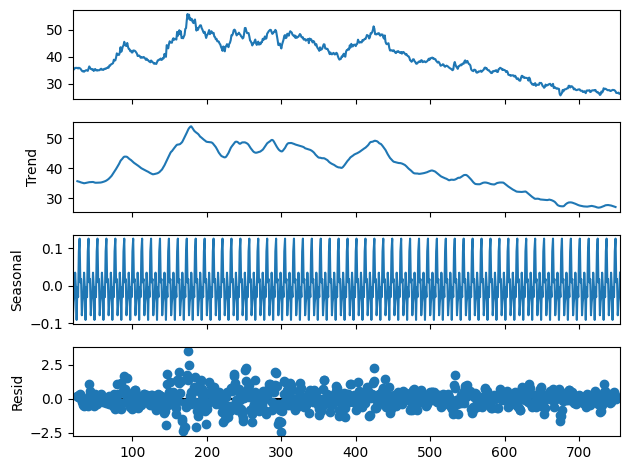

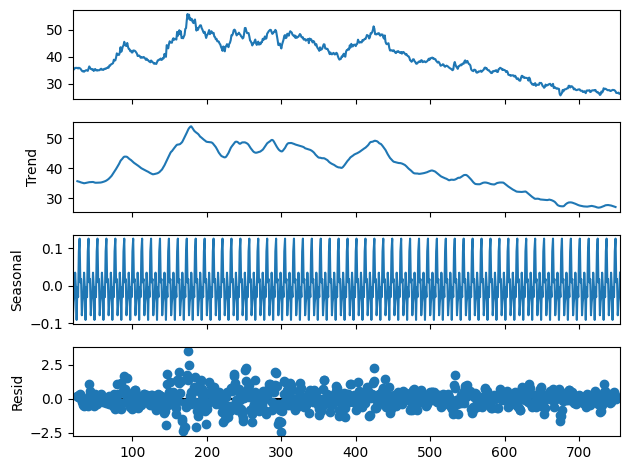

In [404]:
stock_price_res = sm.tsa.seasonal_decompose(stock_price_time_series[['y']],
                                model='additive', period=12)

stock_price_res.plot()

**Stock Return Time Series Model**

In [405]:
stock_return_time_series = pd.DataFrame([aligned_index_data['Date'],aligned_index_data['Stock Returns']]).T.rename(columns={'Date' : 'ds', 'Stock Returns' : 'y'})[['ds','y']]

stock_return_time_series.head(20)

,ds,y
20,2021-05-10 00:00:00-04:00,0.01
21,2021-05-11 00:00:00-04:00,-0.01
22,2021-05-12 00:00:00-04:00,0.01
23,2021-05-13 00:00:00-04:00,0.01
24,2021-05-14 00:00:00-04:00,-0.00
25,2021-05-17 00:00:00-04:00,0.00
26,2021-05-18 00:00:00-04:00,-0.00
27,2021-05-19 00:00:00-04:00,-0.01
28,2021-05-20 00:00:00-04:00,0.01
29,2021-05-21 00:00:00-04:00,-0.00


In [406]:
stock_returns_ts_model = NeuralProphet()

stock_returns_ts_model.set_plotting_backend("matplotlib")

stock_returns_metrics = stock_returns_ts_model.fit(stock_return_time_series,
                    freq='D', epochs=10)

Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [407]:
stock_returns_future = stock_returns_ts_model.make_future_dataframe(stock_return_time_series, periods=365, n_historic_predictions=len(stock_return_time_series))
stock_returns_forecast = stock_returns_ts_model.predict(stock_returns_future)

Predicting: 23it [00:00, ?it/s]

In [408]:
stock_returns_forecast

,ds,y,yhat1,trend,season_yearly,season_weekly
0,2021-05-10 04:00:00,0.01,0.00,-0.00,-0.00,0.00
1,2021-05-11 04:00:00,-0.01,0.00,-0.00,-0.00,0.00
2,2021-05-12 04:00:00,0.01,0.00,-0.00,0.00,0.00
3,2021-05-13 04:00:00,0.01,0.01,-0.00,0.00,0.01
4,2021-05-14 04:00:00,-0.00,0.01,-0.00,0.00,0.01
...,...,...,...,...,...,...
1096,2025-04-07 04:00:00,None,-0.01,-0.01,-0.00,0.00
1097,2025-04-08 04:00:00,None,-0.01,-0.01,-0.00,0.00
1098,2025-04-09 04:00:00,None,-0.01,-0.01,-0.00,0.00
1099,2025-04-10 04:00:00,None,-0.01,-0.01,-0.00,0.01


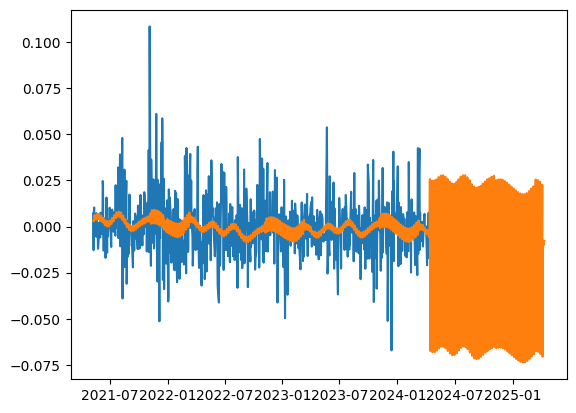

In [409]:
plt.plot(stock_returns_forecast.ds, stock_returns_forecast.y)
plt.plot(stock_returns_forecast.ds, stock_returns_forecast.yhat1)

In [410]:
fig = px.line(stock_returns_forecast, x = 'ds',y = 'yhat1',title = 'Predicted Stock Return')
fig.add_scatter(x=stock_return_time_series['ds'], y = stock_return_time_series['y'], mode='lines')
fig.add_scatter(x=stock_return_time_series['ds'], y = stock_return_time_series['y'].rolling(window=12).mean(), mode='lines')

fig.update_xaxes(
    rangeslider_visible= True
                   )
fig.show()

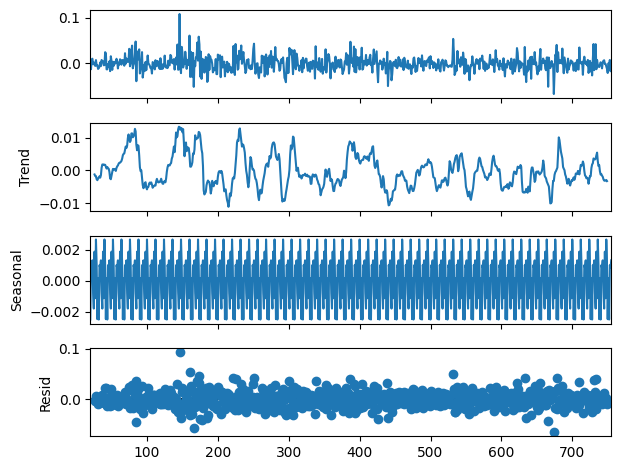

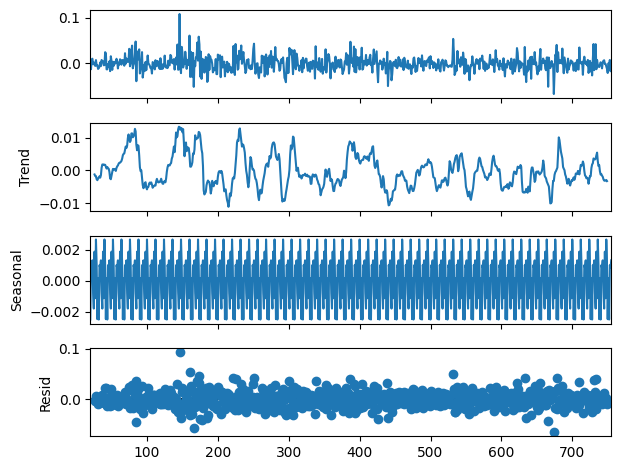

In [411]:
stock_return_res = sm.tsa.seasonal_decompose(stock_return_time_series[['y']],
                                model='additive', period=12)

stock_return_res.plot()

# **Graphs**

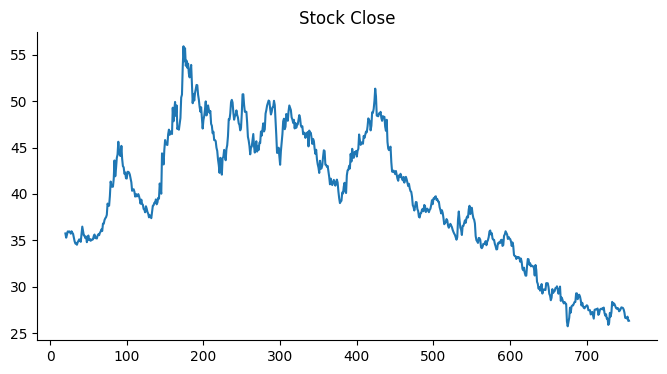

In [412]:
# @title Stock Close
aligned_index_data['Stock Close'].plot(kind='line', figsize=(8, 4), title='Stock Close')
plt.gca().spines[['top', 'right']].set_visible(False)

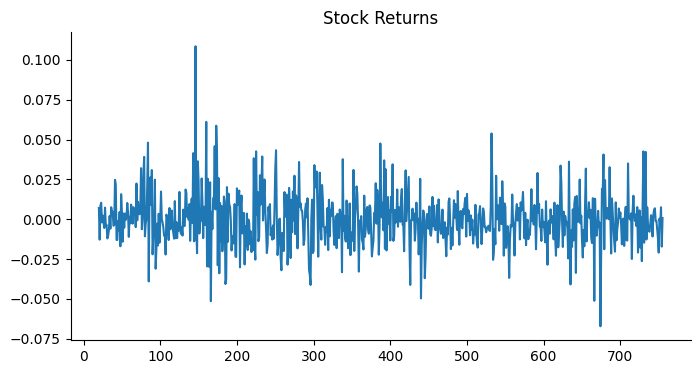

In [413]:
# @title Stock Returns
aligned_index_data['Stock Returns'].plot(kind='line', figsize=(8, 4), title='Stock Returns')
plt.gca().spines[['top', 'right']].set_visible(False)

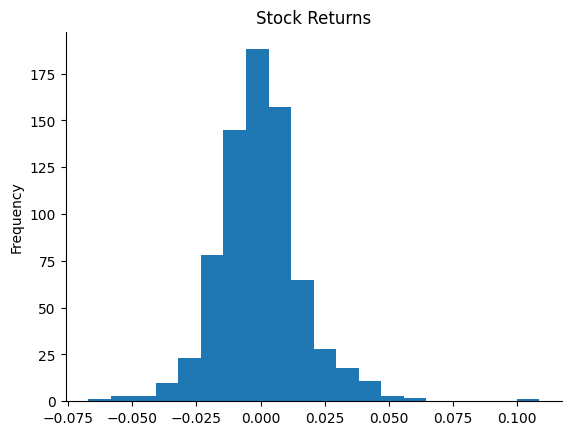

In [414]:
# @title Stock Returns Distribution
aligned_index_data['Stock Returns'].plot(kind='hist', bins=20, title='Stock Returns')
plt.gca().spines[['top', 'right',]].set_visible(False)

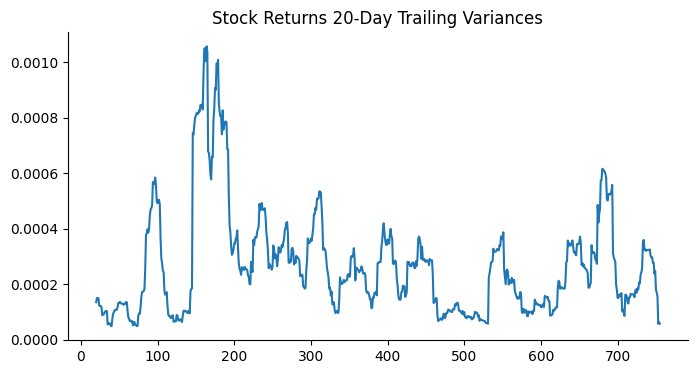

In [415]:
# @title Stock Returns Variance
aligned_index_data['Stock Returns 20-Day Trailing Variances'].plot(kind='line', figsize=(8, 4), title='Stock Returns 20-Day Trailing Variances')
plt.gca().spines[['top', 'right']].set_visible(False)

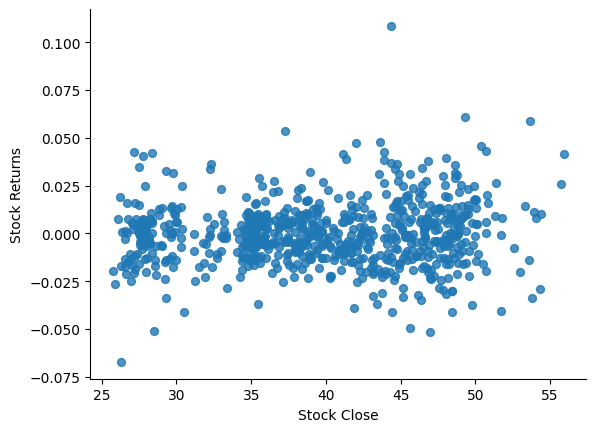

In [416]:
# @title Stock Close vs Stock Returns
aligned_index_data.plot(kind='scatter', x='Stock Close', y='Stock Returns', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

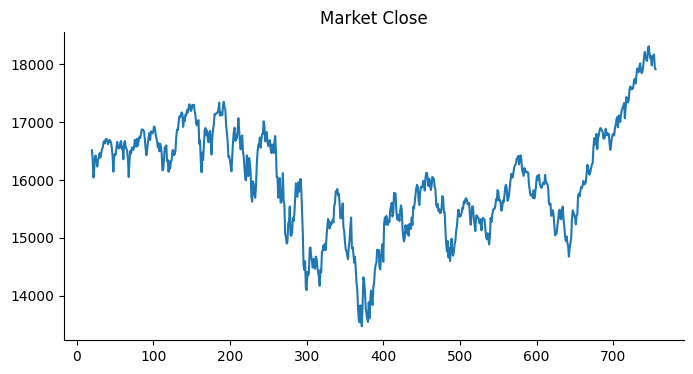

In [417]:
# @title Market Close
aligned_index_data['Market Close'].plot(kind='line', figsize=(8, 4), title='Market Close')
plt.gca().spines[['top', 'right']].set_visible(False)

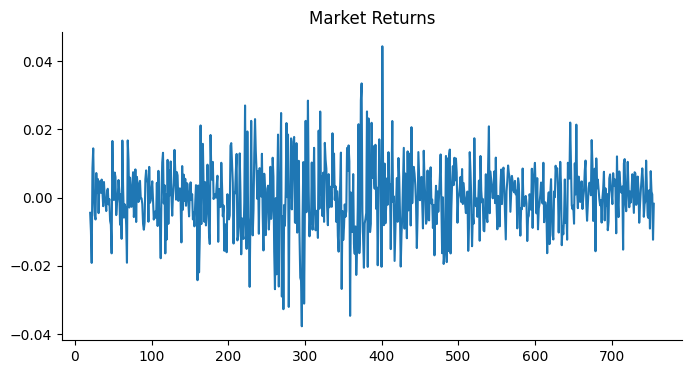

In [418]:
# @title Market Returns
aligned_index_data['Market Returns'].plot(kind='line', figsize=(8, 4), title='Market Returns')
plt.gca().spines[['top', 'right']].set_visible(False)

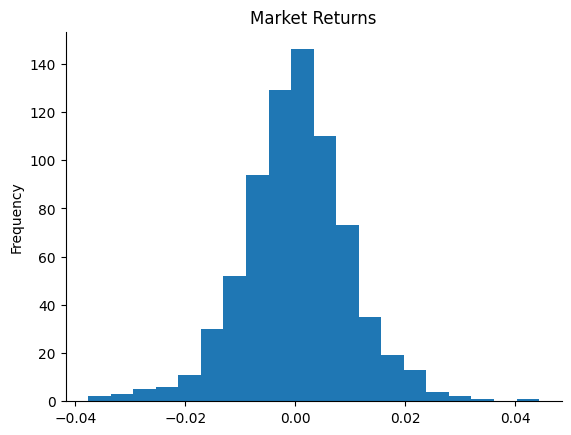

In [419]:
# @title Market Returns Distribution
aligned_index_data['Market Returns'].plot(kind='hist', bins=20, title='Market Returns')
plt.gca().spines[['top', 'right',]].set_visible(False)

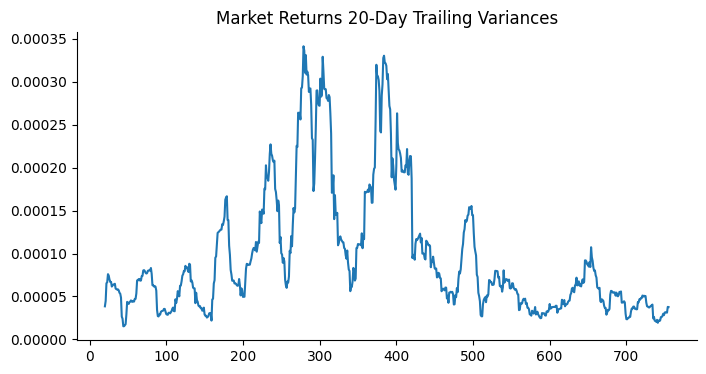

In [420]:
# @title Market Returns Variance
aligned_index_data['Market Returns 20-Day Trailing Variances'].plot(kind='line', figsize=(8, 4), title='Market Returns 20-Day Trailing Variances')
plt.gca().spines[['top', 'right']].set_visible(False)

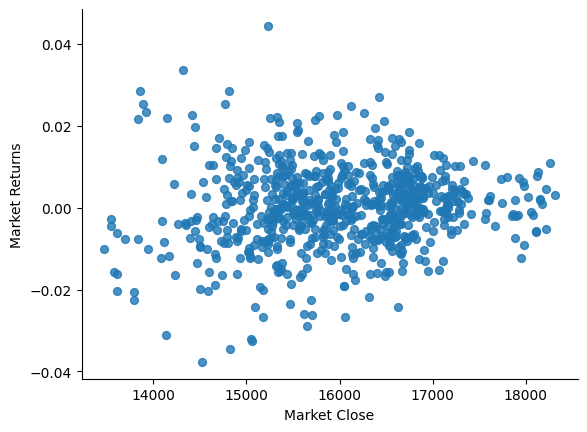

In [421]:
# @title Market Close vs Market Returns
aligned_index_data.plot(kind='scatter', x='Market Close', y='Market Returns', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

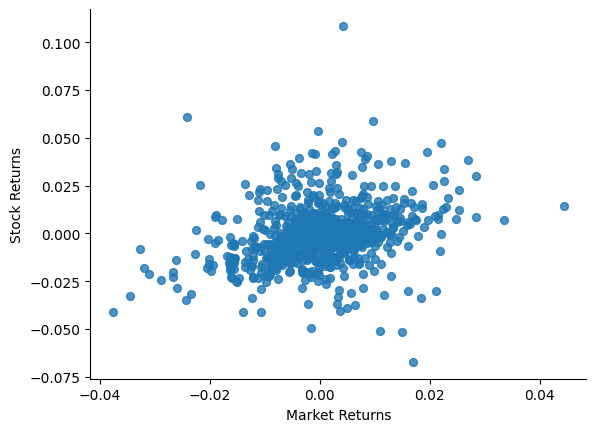

In [422]:
# @title Market Return vs Stock Returns
aligned_index_data.plot(kind='scatter', x='Market Returns', y='Stock Returns', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)